Multiple GPU Training is supported for all models

### UNET Model Arch - 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu


#### DataSet Class

In [ ]:
# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

#### U-Net Architecture

In [ ]:
# Fixed U-Net Architecture - Now removing the sigmoid from the model
class FastUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(FastUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Reduced number of filters
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(128, 256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)  # 256 = 128 (from upconv3) + 128 (from enc3)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)   # 128 = 64 (from upconv2) + 64 (from enc2)
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32)    # 64 = 32 (from upconv1) + 32 (from enc1)
        
        self.final = nn.Conv2d(32, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder - Complete decoder path with all upsampling steps
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Removed sigmoid to use with BCEWithLogitsLoss
        return self.final(dec1)


### UNET Model Arch - 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import KFold
from skimage.filters import threshold_otsu

# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

# Attention Gate Module
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_l, 1),
            nn.BatchNorm2d(F_l)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_l, 1, 1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Enhanced U-Net Architecture
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(EnhancedUNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 48)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(48, 96)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(96, 192)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(192, 384)
        
        # Decoder with Attention Gates
        self.upconv3 = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.attn3 = AttentionGate(192, 192)
        self.dec3 = conv_block(384, 192)
        
        self.upconv2 = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.attn2 = AttentionGate(96, 96)
        self.dec2 = conv_block(192, 96)
        
        self.upconv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        self.attn1 = AttentionGate(48, 48)
        self.dec1 = conv_block(96, 48)
        
        self.final = nn.Conv2d(48, out_channels, 1)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bottleneck)
        dec3 = self.attn3(dec3, enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = self.attn2(dec2, enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = self.attn1(dec1, enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super().__init__()
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target):
        smooth = 1.
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        
    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + \
               (1 - self.bce_weight) * self.dice_loss(pred, target)

# Configuration
image_dir = '/kaggle/input/msdf-mskdataset/face_crop'
mask_dir = '/kaggle/input/msdf-mskdataset/face_crop_segmentation'
batch_size = 32
input_size = 128
epochs = 30
lr = 0.001
patience = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = '/kaggle/working/'
os.makedirs(checkpoint_dir, exist_ok=True)
k_folds = 3

# Data Augmentation
image_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((input_size, input_size), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# Metrics Calculation
def calculate_metrics(pred, target):
    pred = torch.sigmoid(pred)
    pred_bin = (pred > 0.5).float()
    
    # IoU
    intersection = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    # Dice
    dice = (2. * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)
    
    return iou.item(), dice.item()

# Traditional Method
def otsu_segmentation(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('L')
    image = image.resize(target_size)
    img_array = np.array(image)
    threshold = threshold_otsu(img_array)
    binary = torch.tensor(img_array > threshold).float()
    return binary.unsqueeze(0)

# Initialize dataset
dataset = FaceSegmentationDataset(image_dir, mask_dir, image_transform, mask_transform)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Training and Evaluation
final_metrics = {'unet': {'iou': [], 'dice': []}, 'traditional': {'iou': [], 'dice': []}}

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'\n{"="*30}\nFold {fold+1}/{k_folds}\n{"="*30}')
    
    # Data loaders
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler,
                            pin_memory=True, num_workers=4, persistent_workers=True)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler,
                          pin_memory=True, num_workers=4, persistent_workers=True)

    # Model setup
    model = EnhancedUNet().to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    criterion = CombinedLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Training phase
        for images, masks in train_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou, val_dice = 0.0, 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                iou, dice = calculate_metrics(outputs, masks)
                val_iou += iou * images.size(0)
                val_dice += dice * images.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_iou /= len(val_ids)
        val_dice /= len(val_ids)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), f'{checkpoint_dir}/best_fold{fold+1}.pth')
        else:
            early_stop_counter += 1
            
        # Print epoch summary
        print(f'Epoch {epoch+1:02d}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'IoU: {val_iou:.4f} | '
              f'Dice: {val_dice:.4f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Early stopping
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
    
    # Final evaluation
    model.eval()
    fold_iou, fold_dice = 0.0, 0.0
    trad_iou, trad_dice = 0.0, 0.0
    
    with torch.no_grad():
        for idx in val_ids:
            # U-Net evaluation
            image, mask = dataset[idx]
            image = image.unsqueeze(0).to(device)
            pred = model(image)
            iou, dice = calculate_metrics(pred, mask.unsqueeze(0).to(device))
            fold_iou += iou
            fold_dice += dice
            
            # Traditional method evaluation
            img_path = os.path.join(image_dir, dataset.image_files[idx])
            true_mask = mask.squeeze().cpu()
            pred_mask = otsu_segmentation(img_path)
            trad_iou += calculate_metrics(torch.tensor(pred_mask).unsqueeze(0), true_mask.unsqueeze(0))[0]
            trad_dice += calculate_metrics(torch.tensor(pred_mask).unsqueeze(0), true_mask.unsqueeze(0))[1]
    
    # Store metrics
    final_metrics['unet']['iou'].append(fold_iou/len(val_ids))
    final_metrics['unet']['dice'].append(fold_dice/len(val_ids))
    final_metrics['traditional']['iou'].append(trad_iou/len(val_ids))
    final_metrics['traditional']['dice'].append(trad_dice/len(val_ids))
    
    print(f'\nFold {fold+1} Results:')
    print(f'U-Net:    IoU: {final_metrics["unet"]["iou"][-1]:.4f} | Dice: {final_metrics["unet"]["dice"][-1]:.4f}')
    print(f'Traditional: IoU: {final_metrics["traditional"]["iou"][-1]:.4f} | Dice: {final_metrics["traditional"]["dice"][-1]:.4f}')

# Final Summary
print('\n\nFinal Cross-Validation Results:')
print('U-Net Performance:')
print(f'Mean IoU: {np.mean(final_metrics["unet"]["iou"]):.4f} (±{np.std(final_metrics["unet"]["iou"]):.4f})')
print(f'Mean Dice: {np.mean(final_metrics["unet"]["dice"]):.4f} (±{np.std(final_metrics["unet"]["dice"]):.4f})')

print('\nTraditional Method Performance:')
print(f'Mean IoU: {np.mean(final_metrics["traditional"]["iou"]):.4f} (±{np.std(final_metrics["traditional"]["iou"]):.4f})')
print(f'Mean Dice: {np.mean(final_metrics["traditional"]["dice"]):.4f} (±{np.std(final_metrics["traditional"]["dice"]):.4f})')

# Save best model for future inference
best_fold_idx = np.argmax(final_metrics['unet']['iou'])
print(f'\nBest fold: {best_fold_idx + 1} with IoU: {final_metrics["unet"]["iou"][best_fold_idx]:.4f}')

# Load and save the best model
best_model_path = os.path.join(checkpoint_dir, f'best_fold{best_fold_idx + 1}.pth')
final_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

# Initialize model architecture
best_model = EnhancedUNet().to(device)
if torch.cuda.device_count() > 1:
    best_model = nn.DataParallel(best_model)

# Load trained weights
best_model.load_state_dict(torch.load(best_model_path))

# Save complete model for inference
torch.save({
    'model_state_dict': best_model.state_dict(),
    'config': {
        'in_channels': 3,
        'out_channels': 1
    }
}, final_model_path)

print(f'Saved best model from fold {best_fold_idx + 1} to {final_model_path}')


Fold 1/3
Epoch 01/30 | Train Loss: 0.5639 | Val Loss: 0.3746 | IoU: 0.6054 | Dice: 0.7539 | LR: 1.00e-03
Epoch 02/30 | Train Loss: 0.3384 | Val Loss: 0.3280 | IoU: 0.6361 | Dice: 0.7773 | LR: 1.00e-03
Epoch 03/30 | Train Loss: 0.3147 | Val Loss: 0.3020 | IoU: 0.6543 | Dice: 0.7909 | LR: 1.00e-03
Epoch 04/30 | Train Loss: 0.2993 | Val Loss: 0.3154 | IoU: 0.6619 | Dice: 0.7963 | LR: 1.00e-03
Epoch 05/30 | Train Loss: 0.2951 | Val Loss: 0.2887 | IoU: 0.6674 | Dice: 0.8003 | LR: 1.00e-03
Epoch 06/30 | Train Loss: 0.2907 | Val Loss: 0.2917 | IoU: 0.6643 | Dice: 0.7981 | LR: 1.00e-03
Epoch 07/30 | Train Loss: 0.2861 | Val Loss: 0.2959 | IoU: 0.6706 | Dice: 0.8026 | LR: 1.00e-03
Epoch 08/30 | Train Loss: 0.2824 | Val Loss: 0.2838 | IoU: 0.6773 | Dice: 0.8074 | LR: 1.00e-03
Epoch 09/30 | Train Loss: 0.2803 | Val Loss: 0.2873 | IoU: 0.6694 | Dice: 0.8017 | LR: 1.00e-03
Epoch 10/30 | Train Loss: 0.2795 | Val Loss: 0.2803 | IoU: 0.6774 | Dice: 0.8075 | LR: 1.00e-03
Epoch 11/30 | Train Loss: 0.27

<ipython-input-2-f2b924db034a>:307: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{checkpoint_dir}/best_fold{fold+1}.pth'))
<ipython-input


Fold 1 Results:
U-Net:    IoU: 0.6896 | Dice: 0.8080
Traditional: IoU: 0.2597 | Dice: 0.3849

Fold 2/3
Epoch 01/30 | Train Loss: 0.5099 | Val Loss: 0.3795 | IoU: 0.5244 | Dice: 0.6872 | LR: 1.00e-03
Epoch 02/30 | Train Loss: 0.3278 | Val Loss: 0.3102 | IoU: 0.6369 | Dice: 0.7779 | LR: 1.00e-03


### UNET Model Arch 3

#### Load required Libraries

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

#### Dataset and UNET class

In [ ]:
# Custom Dataset Class
class FaceSegmentationDataset(Dataset):
    def __init__(self, face_crop_dir, face_crop_seg_dir, transform=None, mask_transform=None):
        self.face_crop_dir = face_crop_dir
        self.face_crop_seg_dir = face_crop_seg_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Get image files
        self.image_files = [f for f in os.listdir(face_crop_dir) 
                            if os.path.exists(os.path.join(face_crop_seg_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.face_crop_dir, img_name)
        mask_path = os.path.join(self.face_crop_seg_dir, img_name)
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

# U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = double_conv(256, 512)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = double_conv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = double_conv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = double_conv(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        
        # Bridge
        bridge = self.bridge(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bridge)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final_conv(dec1)


#### Loss function and Metric calculation

In [ ]:
# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target):
        smooth = 1.
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        
    def forward(self, pred, target):
        return 0.7 * self.bce(pred, target) + 0.3 * self.dice_loss(pred, target)

# Metrics Calculation
def calculate_metrics(pred, target):
    pred = torch.sigmoid(pred)
    pred_bin = (pred > 0.5).float()
    
    # IoU
    intersection = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    # Dice
    dice = (2. * intersection + 1e-6) / (pred_bin.sum() + target.sum() + 1e-6)
    
    return iou.item(), dice.item()

#### Main

In [13]:
def main():
    # Configuration
    batch_size = 32
    input_size = 128
    max_epochs = 100  # Increased to allow for multiple sessions
    lr = 0.001
    k_folds = 3
    patience = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Kaggle-specific paths
    try:
        face_crop_dir = '/kaggle/input/msdf-mskdataset/face_crop'
        face_crop_seg_dir = '/kaggle/input/msdf-mskdataset/face_crop_segmentation'
        checkpoint_dir = '/kaggle/working'
    except:
        face_crop_dir = '../../../dataset/MSDF/1/face_crop'
        face_crop_seg_dir ='../../../dataset/MSDF/1/face_crop_segmentation'
        checkpoint_dir = './checkpoints'
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Data Augmentation and Transforms
    image_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((input_size, input_size), transforms.InterpolationMode.NEAREST),
        transforms.ToTensor()
    ])
    
    # Initialize dataset
    dataset = FaceSegmentationDataset(face_crop_dir, face_crop_seg_dir, 
                                      image_transform, mask_transform)
    
    # K-Fold Cross Validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Final metrics storage
    final_metrics = {
        'unet': {'iou': [], 'dice': []},
        'traditional': {'iou': [], 'dice': []}
    }
    
    # Cross-Validation Training
    # Cross-Validation Training
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'\n{"="*30}\nFold {fold+1}/{k_folds}\n{"="*30}')
        
        # Checkpoint file for this fold
        checkpoint_file = os.path.join(checkpoint_dir, f'checkpoint_fold{fold+1}.pth')
        best_model_file = os.path.join(checkpoint_dir, f'best_model_fold{fold+1}.pth')
        
        # Data loaders
        train_subsampler = SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, 
                                    sampler=train_subsampler, 
                                    pin_memory=True, num_workers=4)
        val_loader = DataLoader(dataset, batch_size=batch_size, 
                                    sampler=val_subsampler, 
                                    pin_memory=True, num_workers=4)
        
        # Model setup
        model = UNet().to(device)
        criterion = CombinedLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
        
        # Check for existing checkpoint
        start_epoch = 0
        best_val_loss = float('inf')
        
        if os.path.exists(checkpoint_file):
            try:
                print(f"Resuming training from checkpoint: {checkpoint_file}")
                checkpoint = torch.load(checkpoint_file)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print(f"Resuming from epoch {start_epoch}")
            except RuntimeError as e:
                print(f"Error loading checkpoint: {e}. Starting from scratch.")
        
        # Training loop
        early_stop_counter = 0
        
        for epoch in range(start_epoch, max_epochs):
            model.train()
            train_loss = 0.0
            
            for images, masks in train_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validation
            model.eval()
            val_loss = 0.0
            val_iou, val_dice = 0.0, 0.0
            
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)
                    outputs = model(images)
                    
                    loss = criterion(outputs, masks)
                    val_loss += loss.item()
                    
                    iou, dice = calculate_metrics(outputs, masks)
                    val_iou += iou * images.size(0)
                    val_dice += dice * images.size(0)
            
            # Metrics calculation
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_iou /= len(val_ids)
            val_dice /= len(val_ids)
            
            scheduler.step(val_loss)
            
            # Save checkpoint
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, checkpoint_file)
            
            # Early stopping and model saving
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'epoch': epoch + 1,
                    'val_loss': val_loss,
                    'val_iou': val_iou,
                    'val_dice': val_dice
                }, best_model_file)
            else:
                early_stop_counter += 1
            
            print(f'Epoch {epoch+1:02d}/{max_epochs} | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'IoU: {val_iou:.4f} | '
                  f'Dice: {val_dice:.4f}')
            
            if early_stop_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        # Store fold metrics
        final_metrics['unet']['iou'].append(val_iou)
        final_metrics['unet']['dice'].append(val_dice)
    
    # Final summary
    print('\nFinal Cross-Validation Results:')
    print('U-Net Performance:')
    print(f'Mean IoU: {np.mean(final_metrics["unet"]["iou"]):.4f} (±{np.std(final_metrics["unet"]["iou"]):.4f})')
    print(f'Mean Dice: {np.mean(final_metrics["unet"]["dice"]):.4f} (±{np.std(final_metrics["unet"]["dice"]):.4f})')

if __name__ == '__main__':
    main()


Fold 1/3
Epoch 01/100 | Train Loss: 0.2999 | Val Loss: 0.2431 | IoU: 0.7198 | Dice: 0.8368
Epoch 02/100 | Train Loss: 0.2246 | Val Loss: 0.2136 | IoU: 0.7501 | Dice: 0.8570
Epoch 03/100 | Train Loss: 0.2061 | Val Loss: 0.2286 | IoU: 0.7335 | Dice: 0.8460
Epoch 04/100 | Train Loss: 0.1994 | Val Loss: 0.1985 | IoU: 0.7701 | Dice: 0.8699
Epoch 05/100 | Train Loss: 0.1924 | Val Loss: 0.1943 | IoU: 0.7695 | Dice: 0.8695
Epoch 06/100 | Train Loss: 0.1890 | Val Loss: 0.1912 | IoU: 0.7774 | Dice: 0.8745
Epoch 07/100 | Train Loss: 0.1874 | Val Loss: 0.1885 | IoU: 0.7761 | Dice: 0.8737
Epoch 08/100 | Train Loss: 0.1830 | Val Loss: 0.1890 | IoU: 0.7802 | Dice: 0.8762
Epoch 09/100 | Train Loss: 0.1831 | Val Loss: 0.1967 | IoU: 0.7774 | Dice: 0.8745
Epoch 10/100 | Train Loss: 0.1796 | Val Loss: 0.1862 | IoU: 0.7783 | Dice: 0.8752
Epoch 11/100 | Train Loss: 0.1786 | Val Loss: 0.1845 | IoU: 0.7832 | Dice: 0.8782
Epoch 12/100 | Train Loss: 0.1776 | Val Loss: 0.1809 | IoU: 0.7831 | Dice: 0.8781
Epoch 

KeyboardInterrupt: 

### Model Inference (Model 3)

['/kaggle/input/test-images-for-mask-detection-unet-model/wearyoursecondsmile_300264499_384385350542885_3591734752156536125_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/whoslinaria_302349101_391523706441485_5704877354134230761_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/wearmaskandgloves_116910285_141641987573755_5053383579828833868_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/_beccafarrelly_240786056_368518228167746_7609661855390513547_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/transformedinteriors_120844709_647437659293058_6096362744134961425_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/__marydavidson___95029003_160153648755183_3618752210175510986_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/___ignored_____299885635_1229271361249953_2326096657624806736_n.jpg', '/kaggle/input/test-images-for-mask-detection-unet-model/000004_1.jpg', '/kaggle/input/test-images-for-m

<ipython-input-36-1aa850110168>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


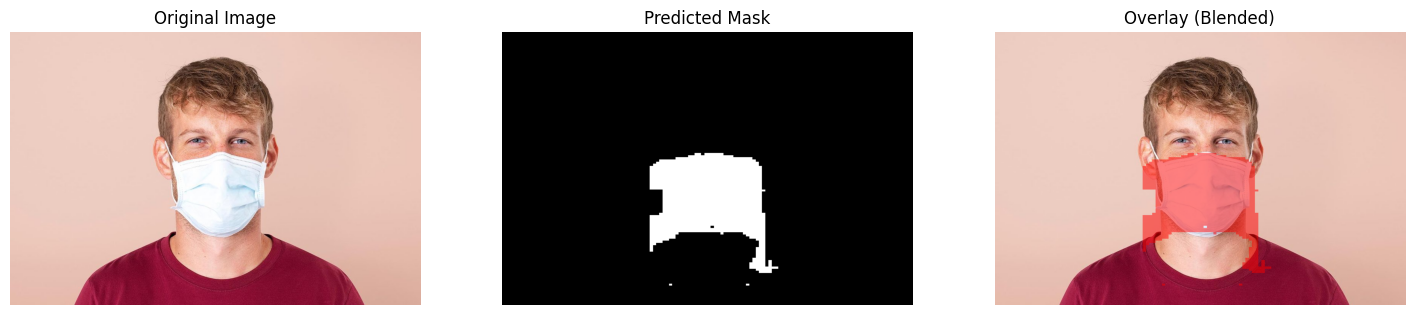

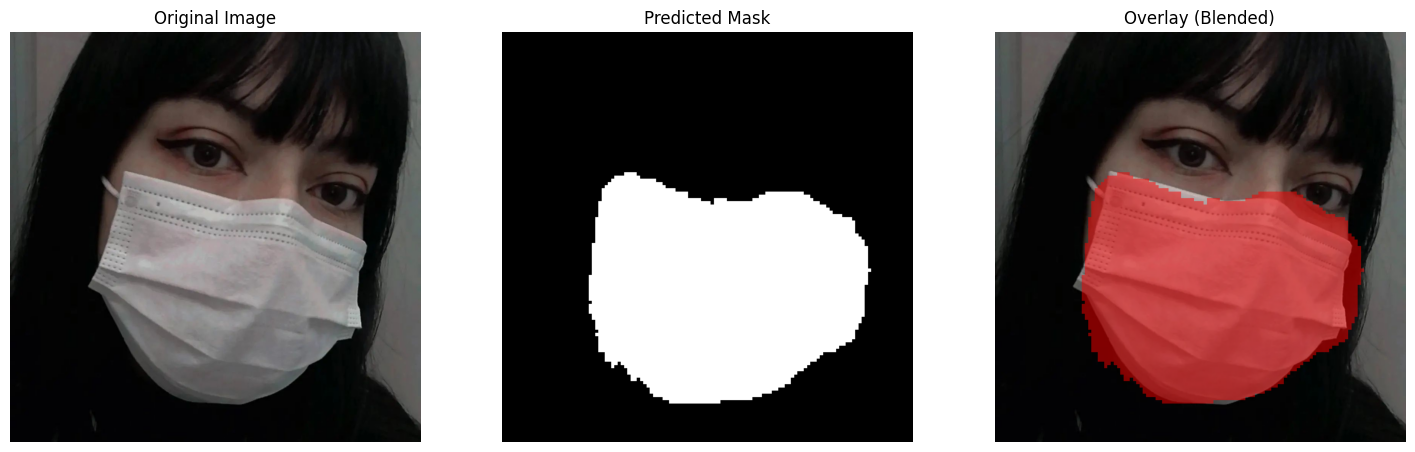

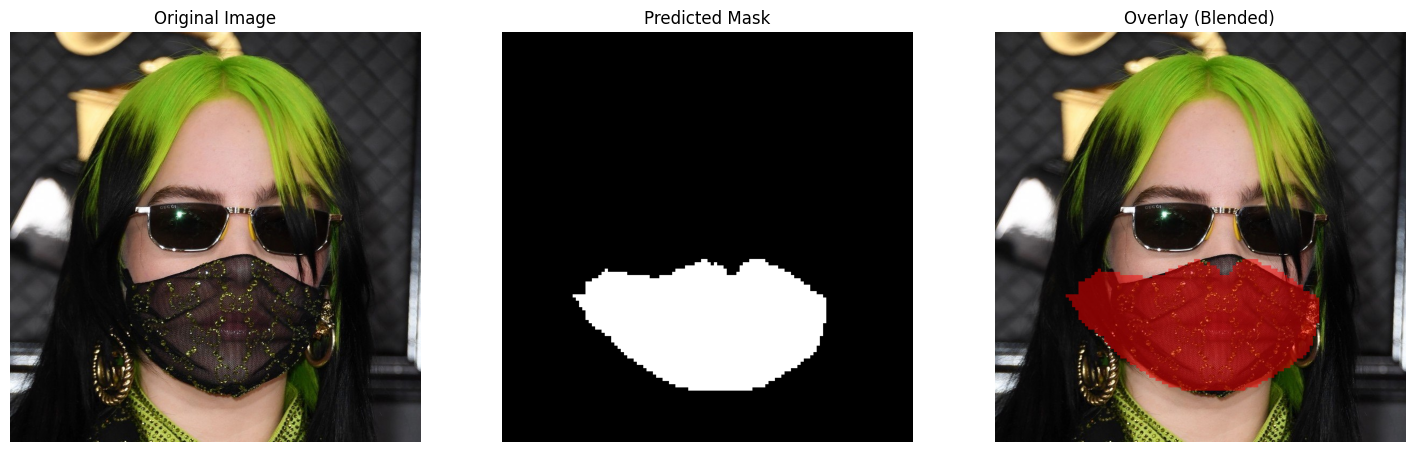

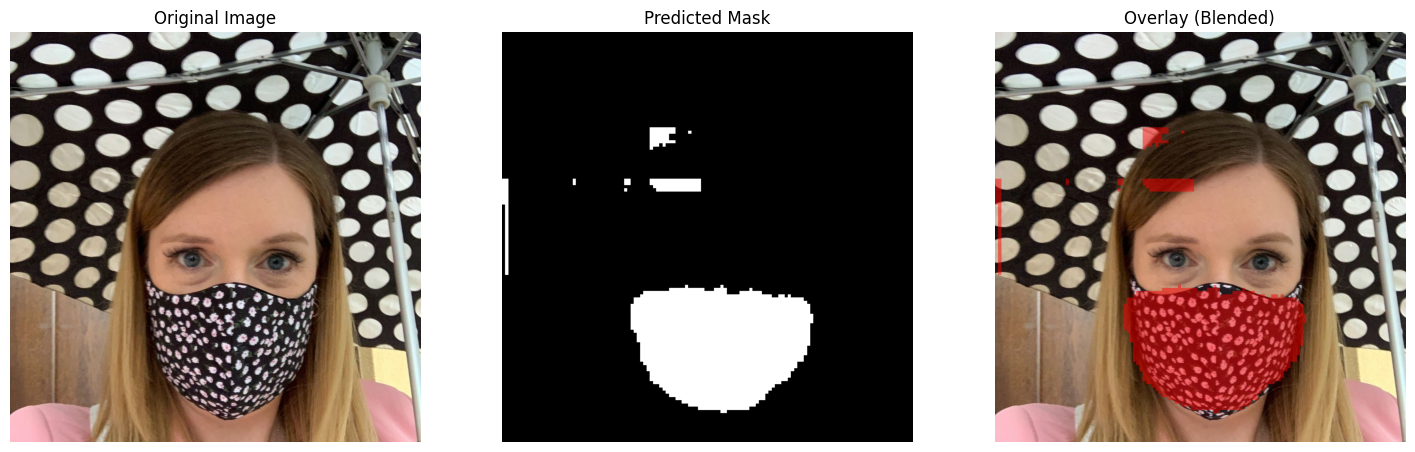

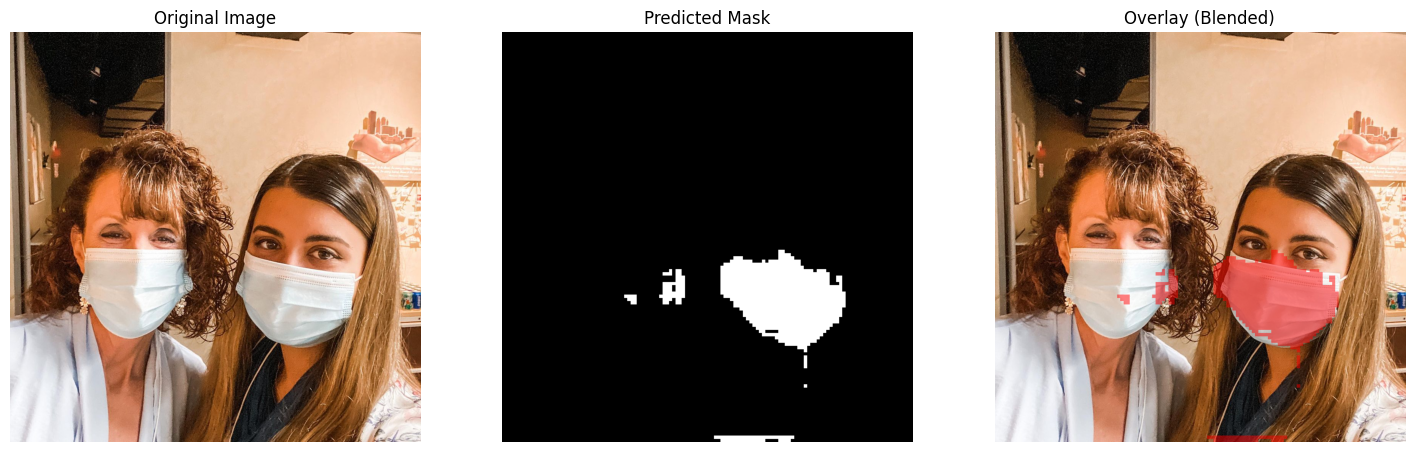

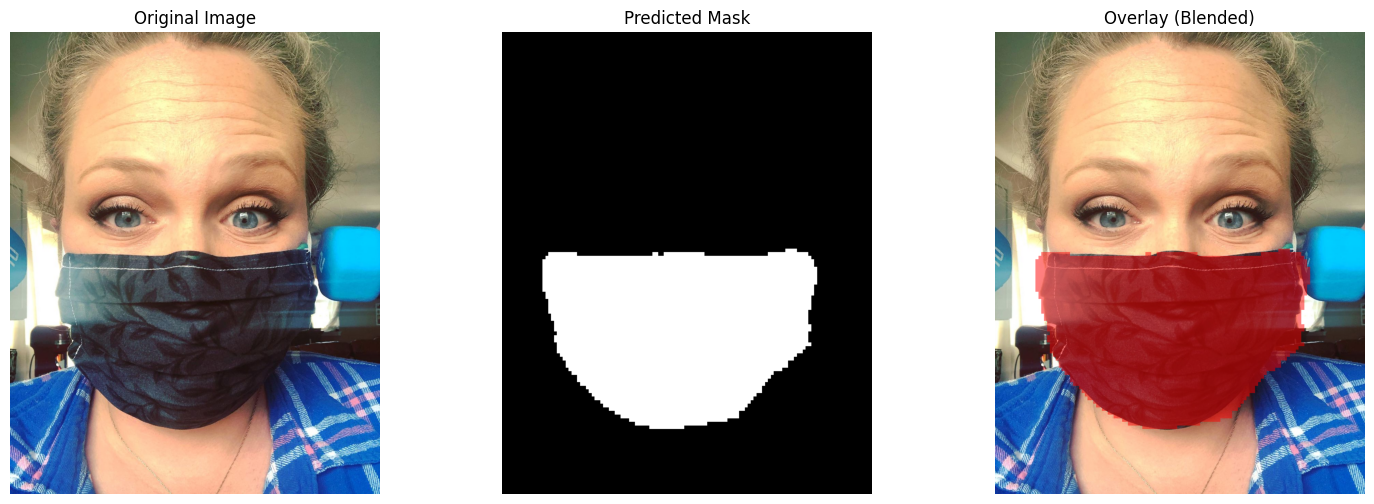

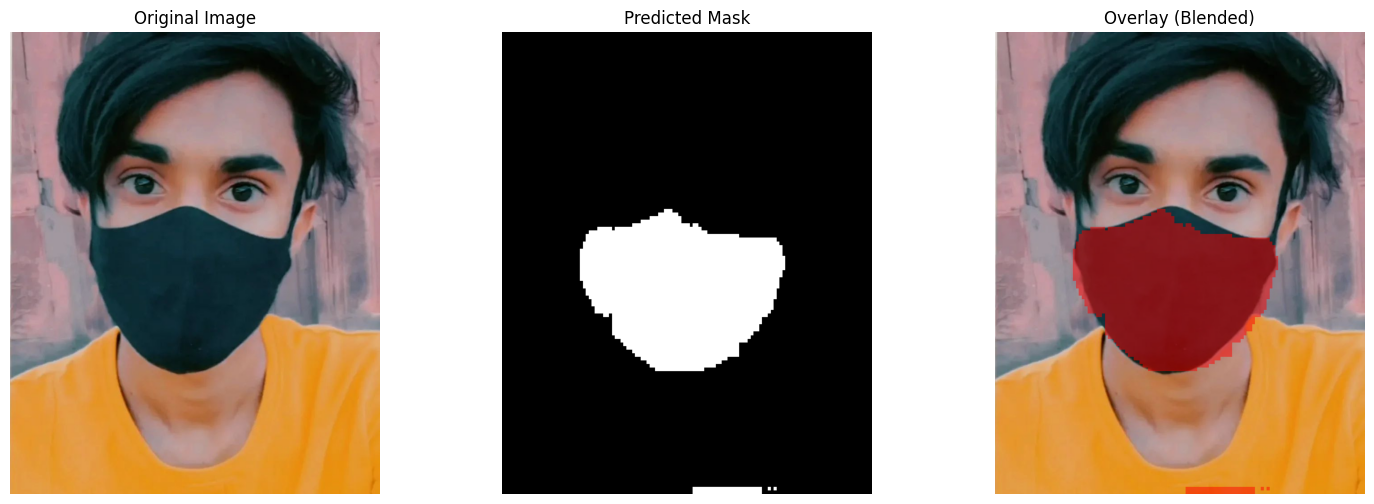

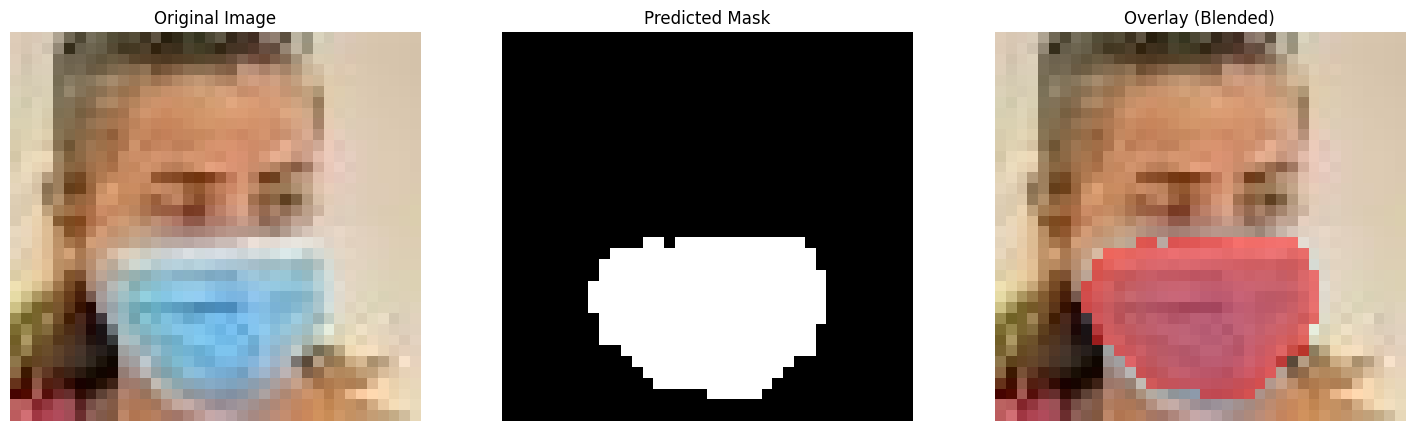

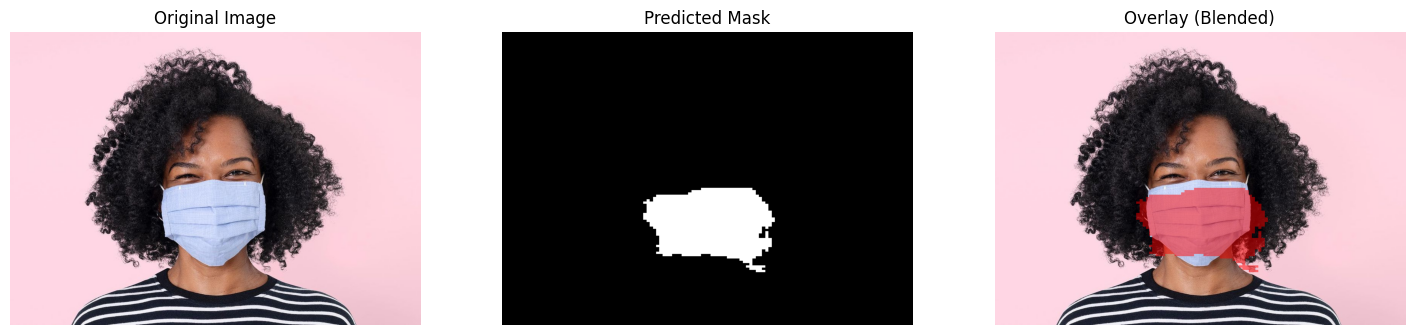

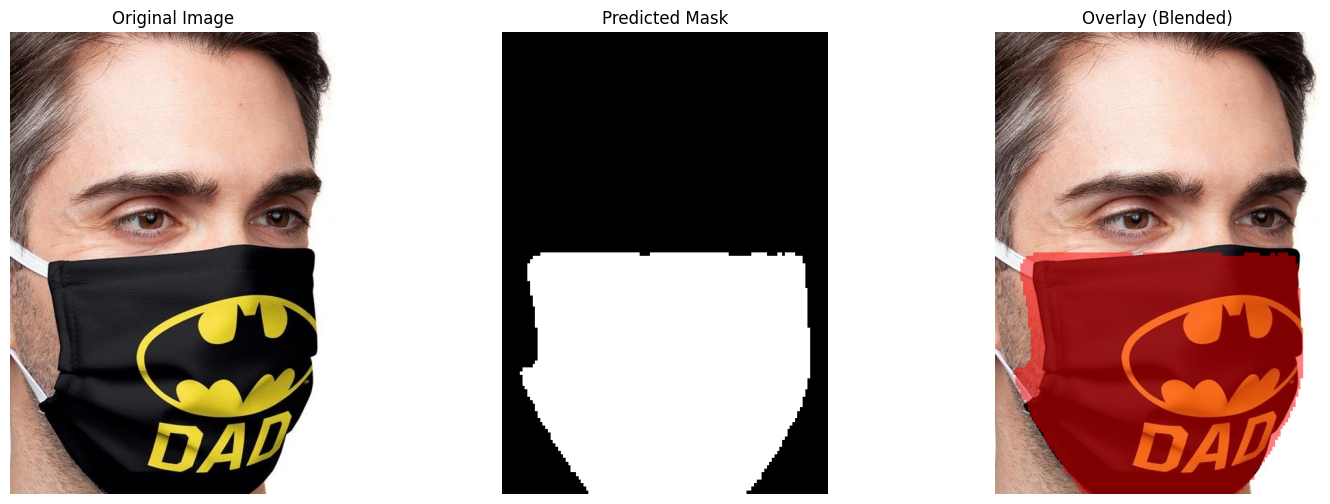

In [36]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the U-Net architecture (must match training exactly)
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = double_conv(256, 512)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = double_conv(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        bridge = self.bridge(self.pool3(enc3))
        
        # Decoder
        dec3 = self.upconv3(bridge)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final_conv(dec1)

def load_model(checkpoint_path, device):
    """Load trained model from checkpoint"""
    model = UNet().to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Handle DataParallel wrapping if used during training
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    if any(k.startswith('module.') for k in state_dict):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model.eval()
    return model

def predict_mask(model, image_path, device, threshold=0.5):
    """Generate prediction mask for a single image"""
    # Preprocessing transforms (must match training)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.sigmoid(output)
        mask = (probs > threshold).float()
    
    # Convert to PIL Image and resize to original dimensions
    mask = mask.squeeze().cpu().numpy()
    mask = Image.fromarray((mask * 255).astype(np.uint8))
    mask = mask.resize(original_size, Image.NEAREST)
    
    return image, mask

def visualize_prediction(image, mask, alpha=0.5):
    """Display original image, mask, and improved overlay"""
    plt.figure(figsize=(18, 6))

    # Convert images to NumPy arrays
    image_np = np.array(image)
    mask_np = np.array(mask)

    # Create a red mask with transparency
    red_mask = np.zeros_like(image_np)
    red_mask[..., 0] = 255  # Set Red channel to 255
    red_mask[..., 1] = 0    # Set Green channel to 0
    red_mask[..., 2] = 0    # Set Blue channel to 0

    # Apply mask only where mask is nonzero
    overlay = np.where(mask_np[..., None] > 127, red_mask, image_np)
    
    # Convert overlay back to PIL Image
    overlay = Image.fromarray(overlay.astype(np.uint8))
    
    # Blend the overlay with the original image
    blended = Image.blend(image, overlay, alpha)

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Overlay with Transparency
    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title('Overlay (Blended)')
    plt.axis('off')

    plt.show()


# Example usage
if __name__ == '__main__':
    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    try:
        checkpoint_path = '/kaggle/working/best_model_fold1.pth'  # Update this path
        test_img_folder = '/kaggle/input/test-images-for-mask-detection-unet-model'
    except:
        checkpoint_path = './checkpoints/best_model_fold1.pth'
        test_img_folder = './test_images'
    import glob
    all_files=glob.glob(test_img_folder+'/*.jpg')
    
    custom_img_list = all_files[:10]
    print(custom_img_list)
    
    # Load model
    model = load_model(checkpoint_path, device)

    for test_img in custom_img_list:
    # Make prediction
        original_image, pred_mask = predict_mask(model, test_img, device)
    
    # Visualize results
        
        visualize_prediction(original_image, pred_mask)